<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tensorflow/tf_low_level_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Low Level TensorFlow, Part II: Training

* https://www.tensorflow.org/guide/low_level_intro#training
* https://developers.google.com/machine-learning/glossary/#gradient_descent
* https://developers.google.com/machine-learning/glossary/#optimizer

In [1]:
# import and check version
import tensorflow as tf
# tf can be really verbose
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [2]:
# a small sanity check, does tf seem to work ok? 
sess = tf.Session()
hello = tf.constant('Hello TF!')
print(sess.run(hello))
sess.close()

b'Hello TF!'


## Transforming an input to a known output

relation between input and output is linear

In [0]:
input = [[1], [2], [3], [4]]
output = [[0], [-1], [-2], [-3]]

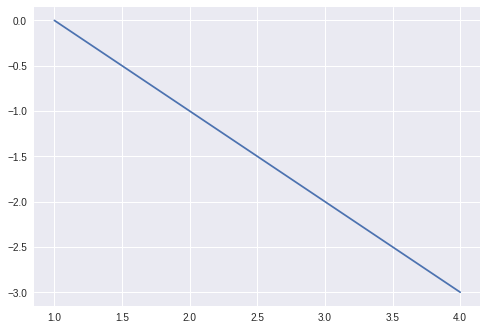

In [4]:
import matplotlib.pyplot as plt

plt.plot(input, output)

In [0]:
x = tf.constant(input, dtype=tf.float32)
y_true = tf.constant(output, dtype=tf.float32)

## Defining the model to train

untrained single unit (neuron) also outputs a line from same input, although another one 

### Understanding how network with a single neuron works in the TensorFlow Playground

https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.98437&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false


In [0]:
y_pred = tf.layers.dense(inputs=x, units=1)

[[0.89087  ]
 [1.78174  ]
 [2.6726098]
 [3.56348  ]]


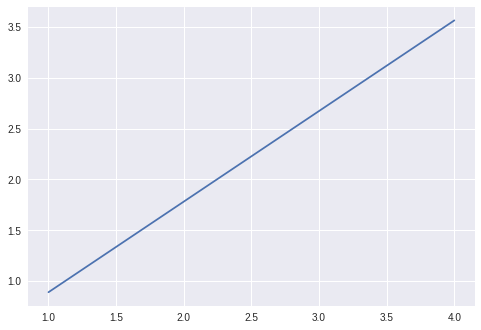

In [7]:
# when you execute this cell, you should see a different line, as the initialization is random
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  output_pred = sess.run(y_pred)
  print(output_pred)
  plt.plot(input, output_pred)

## Loss - Mean Squared Error

Loss function is the prerequisite to training. We need an objective to optimize for. We calculate the difference between what we get as output and what we would like to get.

In [0]:
loss = tf.losses.mean_squared_error(labels=y_true, predictions=y_pred)

In [9]:
# when this loss is zero (which it is not right now) we get the desired output
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  print(sess.run(loss))

30.741087


In [0]:
# move the parameters of our single neuron in the right direction with a pretty high intensity (learning rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)

losses = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# iterations aka epochs, optimizing the parameters of the neuron
for i in range(500):
  
  # executing optimizer and current loss, but only displaying current loss
  _, loss_value = sess.run((train, loss))
  losses.append(loss_value)


In [11]:
  print(sess.run(loss))

0.018698433


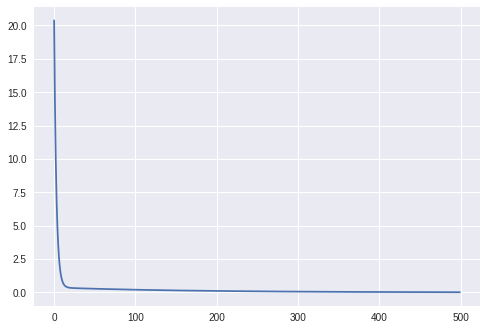

In [12]:
# wet dream of every machine learning person (typically you see a noisy curve only sort of going down)
plt.plot(losses)

[[-0.22079647]
 [-1.106991  ]
 [-1.9931855 ]
 [-2.8793802 ]]


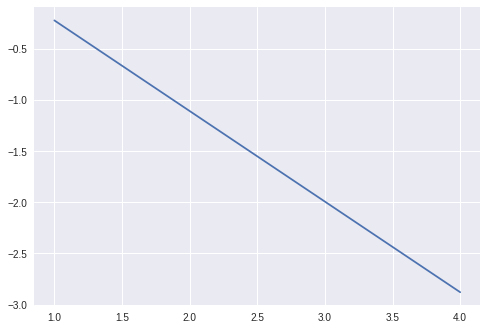

In [13]:
# result after training is not perfect, but almost looks like the same line
output_pred = sess.run(y_pred)
print(output_pred)
plt.plot(input, output_pred)